### Improve accuracy above 0.98398 on simplified MNIST classification - ONLY digits 2 and 7

In [1]:
import math
import numpy as np

# -------------------------------------------------------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------

import keras
import tensorflow as tf
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten

# --------------------------------------------------------

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

/opt/conda/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


### Initialize - Convnet Variables

In [2]:
# Initialize Convnet Parameters

nb_epoch = 12
num_classes = 2
batch_size = 128
img_rows, img_cols = 28, 28

In [3]:
# Load pre-stored MNIST training and test data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Find training and test data corresponding to 2s and 7s
train_picks = np.logical_or(y_train==2,y_train==7)
test_picks = np.logical_or(y_test==2,y_test==7)

# Initialize training and test data corresponding to 2s and 7s

x_train = x_train[train_picks]
x_test = x_test[test_picks]

y_train = np.array(y_train[train_picks]==7,dtype=int)
y_test = np.array(y_test[test_picks]==7,dtype=int)

### Data Samples - Visualize

In [4]:
%matplotlib inline
sns.set(style="ticks")

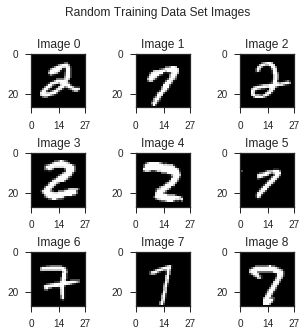

In [5]:
# Visualize few samples of random training data corresponding to 2 and 7

img_num = 9
img_row = 3
img_size = x_train.shape[1]
fig = plt.figure(1, figsize=(3.5,3.5))
fig.subplots_adjust(left=0.125, bottom=0.1, right=1.25, top=1.1,\
                    wspace=0.4,hspace=0.85)

for i in range(9):
    
    plt.subplot(img_row, img_row, i+1)
    plt.title('Image ' + str(i))
    plt.imshow(x_train[i], interpolation="nearest", cmap="gray")        
    plt.axis([0, img_size-1, 0, img_size-1])
    plt.xticks([0,img_size//2,img_size-1])
    plt.gca().invert_yaxis()

fig.text(0.3, 1.25, "Random Training Data Set Images")

### Data Samples - Pre-process 

In [6]:
# Convert test and training data to Tensor

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [7]:
# Normalize test and training data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [8]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (12223, 28, 28, 1)
12223 train samples
2060 test samples


In [9]:
# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Convnet Architecture

In [10]:
def create_model(dense_layer_sizes, kernel_size, dropout):
    
    model = Sequential()
    
    model.add(Conv2D(8, kernel_size, activation='relu', name='conv_1', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size = 2, name='pool_1'))

    model.add(Conv2D(32, kernel_size, activation='relu',name='conv_2'))
    model.add(MaxPooling2D(pool_size = 2, name='pool_2'))
    
    model.add(Dropout(dropout))
    model.add(Flatten())
    
    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size, activation='relu', name='FC_1'))
              
    model.add(Dropout(dropout))    
    model.add(Dense(2, activation='softmax', name='output_layer'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    
    return model

### Grid Search - Training

In [11]:
# Initialize hyper-parameters of convnet architecture

param_grid={
            'dense_layer_sizes': [[64]],
            'dropout':[0, 0.1, 0.2],
            'kernel_size': [3,5]
            }

In [12]:
# Initialize convnet model
my_classifier = KerasClassifier(create_model, batch_size=32, epochs=12, verbose=0)


# Initialize grid search model to find best combination of hyper-parameters
grid_search_calc = GridSearchCV(my_classifier,
                         param_grid=param_grid,
                         n_jobs=-1, verbose=4)

In [13]:
# Train convnet model using grid search hyper-parameters
grid_search_calc.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] dense_layer_sizes=[64], dropout=0, kernel_size=3 ................
[CV] dense_layer_sizes=[64], dropout=0, kernel_size=3 ................
[CV] dense_layer_sizes=[64], dropout=0, kernel_size=3 ................
[CV] dense_layer_sizes=[64], dropout=0, kernel_size=5 ................
[CV]  dense_layer_sizes=[64], dropout=0, kernel_size=3, score=0.993864, total= 2.4min
[CV] dense_layer_sizes=[64], dropout=0, kernel_size=5 ................
[CV]  dense_layer_sizes=[64], dropout=0, kernel_size=3, score=0.994109, total= 2.4min
[CV] dense_layer_sizes=[64], dropout=0, kernel_size=5 ................
[CV]  dense_layer_sizes=[64], dropout=0, kernel_size=3, score=0.995092, total= 2.5min
[CV] dense_layer_sizes=[64], dropout=0.1, kernel_size=3 ..............
[CV]  dense_layer_sizes=[64], dropout=0, kernel_size=5, score=0.997055, total= 3.0min
[CV] dense_layer_sizes=[64], dropout=0.1, kernel_size=3 ..............
[CV]  dense_layer_sizes=[64]

[Parallel(n_jobs=-1)]: Done  16 out of  18 | elapsed: 12.6min remaining:  1.6min


[CV]  dense_layer_sizes=[64], dropout=0.2, kernel_size=5, score=0.993373, total= 2.2min
[CV]  dense_layer_sizes=[64], dropout=0.2, kernel_size=5, score=0.995336, total= 1.7min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 13.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7ff66f026668>,
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'dense_layer_sizes': [[64]], 'dropout': [0, 0.1, 0.2], 'kernel_size': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=4)

### Grid Search - Visualization 

In [14]:
# Diplay results of grid search
grid_search_results = pd.DataFrame(grid_search_calc.cv_results_)
grid_search_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_dense_layer_sizes,param_dropout,param_kernel_size,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,142.215035,2.968649,0.994355,0.997177,[64],0,3,"{'dense_layer_sizes': [64], 'dropout': 0, 'ker...",4,0.995092,0.996318,0.993864,0.997791,0.994109,0.997423,1.558060,0.204389,0.000531,0.000626
1,189.447193,4.062191,0.995418,0.998077,[64],0,5,"{'dense_layer_sizes': [64], 'dropout': 0, 'ker...",1,0.997055,0.997668,0.993864,0.998650,0.995336,0.997914,9.486115,0.842561,0.001304,0.000417
2,167.677652,2.439427,0.993782,0.996073,[64],0.1,3,"{'dense_layer_sizes': [64], 'dropout': 0.1, 'k...",5,0.994110,0.995827,0.992882,0.996319,0.994354,0.996073,4.713889,0.054366,0.000644,0.000201
3,192.645233,3.494883,0.995091,0.997055,[64],0.1,5,"{'dense_layer_sizes': [64], 'dropout': 0.1, 'k...",2,0.996810,0.997054,0.993127,0.996932,0.995336,0.997178,0.681188,0.419691,0.001513,0.000100
4,157.020991,2.668001,0.993537,0.996237,[64],0.2,3,"{'dense_layer_sizes': [64], 'dropout': 0.2, 'k...",6,0.994601,0.996318,0.992636,0.996073,0.993373,0.996319,2.018807,0.150180,0.000811,0.000116
5,137.460903,1.745984,0.994764,0.997096,[64],0.2,5,"{'dense_layer_sizes': [64], 'dropout': 0.2, 'k...",3,0.995583,0.996932,0.993373,0.997178,0.995336,0.997178,33.686120,0.493211,0.000989,0.000116


In [15]:
# Function to plot test/training accuracy of grid search
   
def plot_accuracy(mean_score, acc_type):
    
    graph_train = sns.factorplot(x="param_dropout", y=mean_score, col="param_kernel_size", \
                   data=grid_search_results, saturation=5, \
                   kind="bar", ci=None, aspect=.7);

    (graph_train.set_axis_labels("Dropout", acc_type)
               .set_xticklabels(["0", "0.1", "0.2"])
               .set_titles("Filter: {col_name} * {col_name} ")
               .set(ylim=(0.992, .998))
               .despine(left=True))

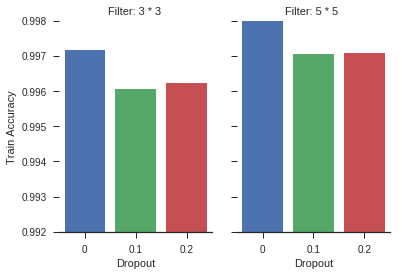

In [16]:
# Plot training accuracy for different combination of hyper-parameters
plot_accuracy("mean_train_score", "Train Accuracy")

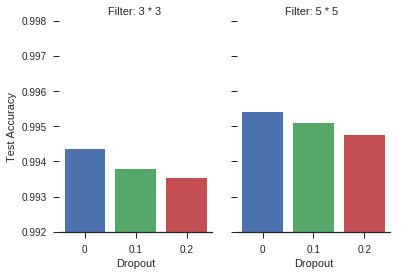

In [17]:
# Plot test accuracy for different combination of hyper-parameters
plot_accuracy("mean_test_score", "Test Accuracy")

### Grid Search - Best Model

In [18]:
# Display best combination Of hyper-parameters found using grid search
print('The parameters of the best model are: ')
print(grid_search_calc.best_params_)

The parameters of the best model are: 
{'dense_layer_sizes': [64], 'dropout': 0, 'kernel_size': 5}


In [19]:
# Print test accuracy of best model
# Save best model found during grid search
# Reference - http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

best_model = grid_search_calc.best_estimator_.model

metric_names = best_model.metrics_names
metric_values = best_model.evaluate(x_test, y_test)

for metric, value in zip(metric_names, metric_values):
    print(metric, ': ', value)

2016/2060 [============================>.] - ETA: 0sloss :  0.0166401620436
acc :  0.994174757282


In [20]:
# Display architecture of best convet model found using grid search
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 12, 12, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 8, 8, 32)          6432      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
FC_1 (Dense)                 (None, 64)                32832     
__________

### Best Model - Load and Save 

In [21]:
# Code to save, load and visualize results of grid search in a file

"""

    from keras.models import load_model

    # Save Best Model
    best_model.save('best_model.h5')

    # Delete Existing Model
    del best_model  

    # Returns Compiled Model
    model = load_model('best_model.h5')

    # Install HDF5 and h5py to visualize stored results
    model.save_weights('my_model_weights.h5')
    model.load_weights('my_model_weights.h5')

"""

"\n\n    from keras.models import load_model\n\n    # Save Best Model\n    best_model.save('best_model.h5')\n\n    # Delete Existing Model\n    del best_model  \n\n    # Returns Compiled Model\n    model = load_model('best_model.h5')\n\n    # Install HDF5 and h5py to visualize stored results\n    model.save_weights('my_model_weights.h5')\n    model.load_weights('my_model_weights.h5')\n\n"

### Best Model - Visualize Output

In [22]:
# Function to extract convolution output using Keras in-built function  

def get_conv_output(model, input_layer, output_layer):
    
    # K.function converts tensor to array    
    get_layer_output = K.function([model.layers[input_layer].input],
                                  [model.layers[output_layer].output])

    return get_layer_output([x_train])[0]

In [23]:
# Function to convert weights in form of tensor to array with help of keras + tensorflow 

def get_weight_output(model, input_layer, ignore):
    
    # Initialize Session 
    sess = tf.InteractiveSession()
    K.set_session(sess)
    
    # Initialize Variables in Session
    tf.global_variables_initializer().run()
    
    # Extract weight values of i/p layer
    weight = model.layers[input_layer].weights[0]
    
    # Convert weight value in tensor form to array
    weight = sess.run(weight)
   
    # Ignore dimension of tensor having only 1 value
    if ignore == True:
        weight = np.squeeze(weight, axis=None)
    
    return weight

In [24]:
# Function to visualize output of convolution layer

def visualize_convolution_output(conv_output, layer_num):
    
    filter_size = conv_output.shape[1]
    filter_count = conv_output.shape[-1]
    dim = math.ceil(math.sqrt(filter_count))

    fig = plt.figure(1, figsize=(dim,dim))
    fig.subplots_adjust(left=0.125, bottom=0.1, right=1.25, top=1.1,\
                        wspace=0.4,hspace=0.85)
    
    for i in range(filter_count):
        plt.subplot(dim, dim, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(conv_output[0,:,:,i], interpolation="nearest", cmap="gray")        
        plt.axis([0, filter_size-1, 0, filter_size-1])
        plt.xticks([0,filter_size//2,filter_size-1])
        plt.gca().invert_yaxis()
        
    fig.text(0.3, 1.25, "Output of Convolution Layer  " + str(layer_num))

In [25]:
# Function to visualize weights of convolution layer

def visualize_weight_output(weight, layer_num, ignore):

    filter_size = weight.shape[0]
    filter_count = weight.shape[-1]
    dim = math.ceil(math.sqrt(filter_count))

    fig = plt.figure(2, figsize=(dim,dim))
    fig.subplots_adjust(left=0.125, bottom=0.1, right=1.25, top=1.1,\
                        wspace=0.4,hspace=0.85)

    for i in range(filter_count):

        plt.subplot(dim, dim, i+1)
        plt.title('Filter ' + str(i))
        
        if ignore == True:
            plt.imshow(weight[:,:,i], interpolation="nearest", cmap="gray")
        else:
            plt.imshow(weight[0,:,:,i], interpolation="nearest", cmap="gray")
        
        plt.axis([0, filter_size-1, 0, filter_size-1])
        plt.xticks([0,filter_size//2,filter_size-1])
        plt.gca().invert_yaxis()

    fig.text(0.25, 1.25, "Weights of Convolution Layer  " + str(layer_num))

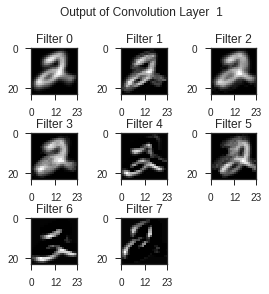

In [26]:
# Visualize Output of Convolution Layer 1

conv_output_1 = get_conv_output(best_model, 0, 0)
visualize_convolution_output(conv_output_1, 1)

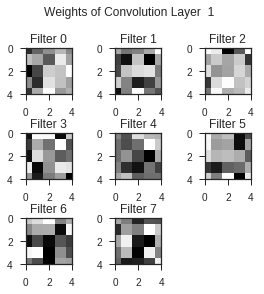

In [27]:
# Visualize Weight of Convolution Layer 1

weight_output_1 = get_weight_output(best_model, 0, True)
visualize_weight_output(weight_output_1, 1, True)

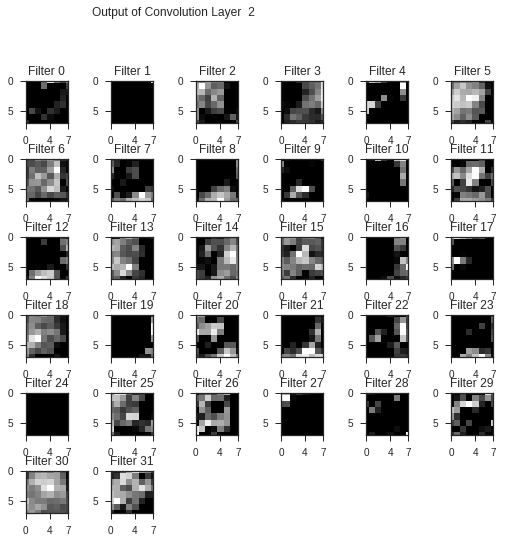

In [28]:
# Visualize Output of Convolution Layer 2

conv_output_2 = get_conv_output(best_model, 0, 2)
visualize_convolution_output(conv_output_2, 2)

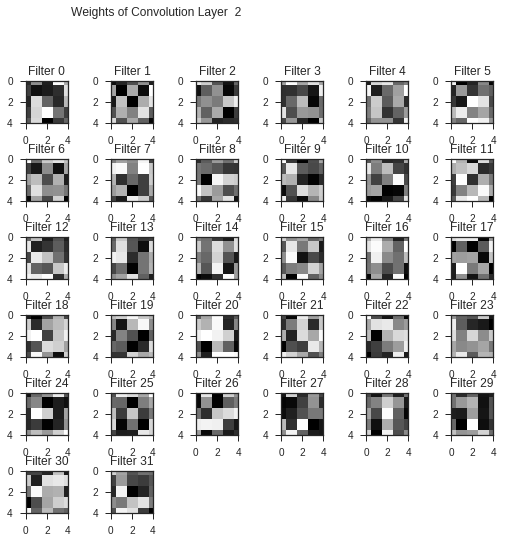

In [29]:
# Visualize Weight of Convolution Layer 2

weight_output_2 = get_weight_output(best_model, 2, False)
visualize_weight_output(weight_output_2, 2, False)